In [12]:
from __future__ import print_function, division
import sys
sys.path.append('core')

import argparse
import os
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
from raft import RAFT
import evaluate
from core import datasets

from torch.utils.tensorboard import SummaryWriter

try:
    from torch.cuda.amp import GradScaler
except:
    # dummy GradScaler for PyTorch < 1.6
    class GradScaler:
        def __init__(self):
            pass
        def scale(self, loss):
            return loss
        def unscale_(self, optimizer):
            pass
        def step(self, optimizer):
            optimizer.step()
        def update(self):
            pass


# exclude extremly large displacements
MAX_FLOW = 400
SUM_FREQ = 100
VAL_FREQ = 5000


def sequence_loss(flow_preds, flow_gt, valid, gamma=0.8, max_flow=MAX_FLOW):
    """ Loss function defined over sequence of flow predictions """

    n_predictions = len(flow_preds)    
    flow_loss = 0.0

    # exlude invalid pixels and extremely large diplacements
    mag = torch.sum(flow_gt**2, dim=1).sqrt()
    valid = (valid >= 0.5) & (mag < max_flow)

    for i in range(n_predictions):
        i_weight = gamma**(n_predictions - i - 1)
        i_loss = (flow_preds[i] - flow_gt).abs()
        flow_loss += i_weight * (valid[:, None] * i_loss).mean()

    epe = torch.sum((flow_preds[-1] - flow_gt)**2, dim=1).sqrt()
    epe = epe.view(-1)[valid.view(-1)]

    metrics = {
        'epe': epe.mean().item(),
        '1px': (epe < 1).float().mean().item(),
        '3px': (epe < 3).float().mean().item(),
        '5px': (epe < 5).float().mean().item(),
    }

    return flow_loss, metrics


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def fetch_optimizer(args, model):
    """ Create the optimizer and learning rate scheduler """
    optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.wdecay, eps=args.epsilon)

    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, args.lr, args.num_steps+100,
        pct_start=0.05, cycle_momentum=False, anneal_strategy='linear')

    return optimizer, scheduler
    

class Logger:
    def __init__(self, model, scheduler):
        self.model = model
        self.scheduler = scheduler
        self.total_steps = 0
        self.running_loss = {}
        self.writer = None

    def _print_training_status(self):
        metrics_data = [self.running_loss[k]/SUM_FREQ for k in sorted(self.running_loss.keys())]
        training_str = "[{:6d}, {:10.7f}] ".format(self.total_steps+1, self.scheduler.get_last_lr()[0])
        metrics_str = ("{:10.4f}, "*len(metrics_data)).format(*metrics_data)
        
        # print the training status
        print(training_str + metrics_str)

        if self.writer is None:
            self.writer = SummaryWriter()

        for k in self.running_loss:
            self.writer.add_scalar(k, self.running_loss[k]/SUM_FREQ, self.total_steps)
            self.running_loss[k] = 0.0

    def push(self, metrics):
        self.total_steps += 1

        for key in metrics:
            if key not in self.running_loss:
                self.running_loss[key] = 0.0

            self.running_loss[key] += metrics[key]

        if self.total_steps % SUM_FREQ == SUM_FREQ-1:
            self._print_training_status()
            self.running_loss = {}

    def write_dict(self, results):
        if self.writer is None:
            self.writer = SummaryWriter()

        for key in results:
            self.writer.add_scalar(key, results[key], self.total_steps)

    def close(self):
        self.writer.close()


def train(args):

    model = nn.DataParallel(RAFT(args), device_ids=args.gpus)
    print("Parameter Count: %d" % count_parameters(model))

    if args.restore_ckpt is not None:
        model.load_state_dict(torch.load(args.restore_ckpt), strict=False)

    model.cuda()
    model.train()

    if args.stage != 'chairs':
        model.module.freeze_bn()

    train_loader = datasets.fetch_dataloader(args)
    optimizer, scheduler = fetch_optimizer(args, model)

    total_steps = 0
    scaler = GradScaler(enabled=args.mixed_precision)
    logger = Logger(model, scheduler)

    VAL_FREQ = 5000
    add_noise = True

    should_keep_training = True
    while should_keep_training:

        for i_batch, data_blob in enumerate(train_loader):
            optimizer.zero_grad()
            image1, image2, flow, valid = [x.cuda() for x in data_blob]

            if args.add_noise:
                stdv = np.random.uniform(0.0, 5.0)
                image1 = (image1 + stdv * torch.randn(*image1.shape).cuda()).clamp(0.0, 255.0)
                image2 = (image2 + stdv * torch.randn(*image2.shape).cuda()).clamp(0.0, 255.0)

            flow_predictions = model(image1, image2, iters=args.iters)            

            loss, metrics = sequence_loss(flow_predictions, flow, valid, args.gamma)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)                
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
            
            scaler.step(optimizer)
            scheduler.step()
            scaler.update()

            logger.push(metrics)

            if total_steps % VAL_FREQ == VAL_FREQ - 1:
                PATH = 'checkpoints/%d_%s.pth' % (total_steps+1, args.name)
                torch.save(model.state_dict(), PATH)

                results = {}
                for val_dataset in args.validation:
                    if val_dataset == 'chairs':
                        results.update(evaluate.validate_chairs(model.module))
                    elif val_dataset == 'sintel':
                        results.update(evaluate.validate_sintel(model.module))
                    elif val_dataset == 'kitti':
                        results.update(evaluate.validate_kitti(model.module))

                logger.write_dict(results)
                
                model.train()
                if args.stage != 'chairs':
                    model.module.freeze_bn()
            
            total_steps += 1

            if total_steps > args.num_steps:
                should_keep_training = False
                break

    logger.close()
    PATH = 'checkpoints/%s.pth' % args.name
    torch.save(model.state_dict(), PATH)

    return PATH

In [13]:
from argparse import Namespace
import os
import torch
import numpy as np

# Define your default arguments and any modifications using Namespace
args = Namespace(
    name='raft-maia-1',
    stage='maia',
    validation=['maia'],
    gpus=[0],
    num_steps=1200,
    batch_size=8,
    lr=0.00025,
    image_size=[368, 496],
    wdecay=0.0001,
    mixed_precision=True,
    # Set defaults for any arguments you did not explicitly set above
    restore_ckpt=None,
    small=True,
    iters=12,
    epsilon=1e-8,
    clip=1.0,
    dropout=0.0,
    gamma=0.8,
    add_noise=False
)

torch.manual_seed(1234)
np.random.seed(1234)

if not os.path.isdir('checkpoints'):
    os.mkdir('checkpoints')

#from . import datasets
# Now you can call train with the args Namespace
train(args)
#model = nn.DataParallel(RAFT(args), device_ids=args.gpus)

Parameter Count: 990162
['F', 'FlowAugmentor', 'FlowDataset', 'FlyingChairs', 'FlyingThings3D', 'HD1K', 'KITTI', 'MpiSintel', 'SparseFlowAugmentor', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'data', 'fetch_dataloader', 'frame_utils', 'glob', 'math', 'np', 'os', 'osp', 'random', 'torch']
Training with 208200 image pairs


/home/martin/anaconda3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/martin/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[   100,  0.0002429]     0.0506,     0.2625,     0.4205,    16.8101, 


2023-11-03 13:11:42.572015: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[   200,  0.0002227]     0.1085,     0.4162,     0.5583,    13.7624, 
[   300,  0.0002024]     0.1365,     0.4636,     0.5990,    14.0977, 
[   400,  0.0001822]     0.1465,     0.4963,     0.6331,    12.0224, 
[   500,  0.0001619]     0.1877,     0.5358,     0.6600,    11.3352, 
[   600,  0.0001417]     0.2020,     0.5670,     0.6831,    11.6144, 
[   700,  0.0001215]     0.2292,     0.5732,     0.6793,    12.2944, 
[   800,  0.0001012]     0.2755,     0.6234,     0.7216,    10.3139, 
[   900,  0.0000810]     0.2866,     0.6167,     0.7116,    10.9325, 
[  1000,  0.0000607]     0.2960,     0.6356,     0.7267,    10.5612, 
[  1100,  0.0000405]     0.3035,     0.6276,     0.7211,    10.4707, 
[  1200,  0.0000202]     0.3390,     0.6574,     0.7431,     9.7088, 


'checkpoints/raft-sintel.pth'

In [18]:
train_loader = datasets.fetch_dataloader(args)

Training with 208200 image pairs


image1:
	Shape: torch.Size([8, 3, 368, 496])
	Min: 0.0
	Max: 255.0
image2:
	Shape: torch.Size([8, 3, 368, 496])
	Min: 0.0
	Max: 255.0
flow:
	Shape: torch.Size([8, 2, 368, 496])
	Min: -442.7021484375
	Max: 242.3783721923828
valid:
	Shape: torch.Size([8, 368, 496])
	Min: 1.0
	Max: 1.0


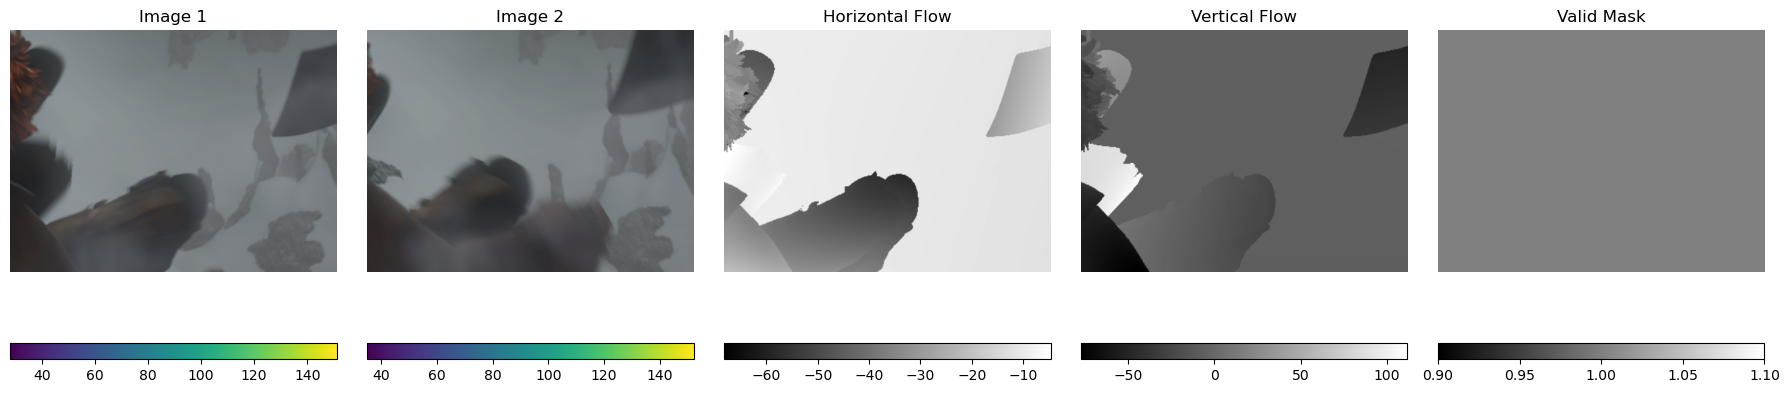

In [21]:
import matplotlib.pyplot as plt
from matplotlib import cm

# Now we will print the shapes, minimum, and maximum values for each tensor
tensors = {'image1': image1, 'image2': image2, 'flow': flow, 'valid': valid}
for name, tensor in tensors.items():
    print(f"{name}:")
    print(f"\tShape: {tensor.shape}")
    print(f"\tMin: {tensor.min().item()}")
    print(f"\tMax: {tensor.max().item()}")
    
    
# Assuming train_loader is already defined and is a PyTorch DataLoader instance
# Let's visualize only the first batch from the training loader
data_blob = next(iter(train_loader))
image1, image2, flow, valid = [x.cpu().detach() for x in data_blob]

num_samples = image1.shape[0]  # Assuming image1.shape[0] is the batch size

# Let's visualize only the first item from the batch
index = 0  # Change this index if you want to visualize different samples from the batch

# Plotting the first image
plt.figure(figsize=(18, 5))

plt.subplot(1, 5, 1)
plt.imshow(image1[index].permute(1, 2, 0).numpy().astype(np.uint8))
plt.title('Image 1')
plt.axis('off')
plt.colorbar(orientation='horizontal')

# Plotting the second image
plt.subplot(1, 5, 2)
plt.imshow(image2[index].permute(1, 2, 0).numpy().astype(np.uint8))
plt.title('Image 2')
plt.axis('off')
plt.colorbar(orientation='horizontal')

# Plotting the horizontal flow component
plt.subplot(1, 5, 3)
hor_flow = flow[index][0].numpy()
plt.imshow(hor_flow, cmap='gray')
plt.title('Horizontal Flow')
plt.axis('off')
plt.colorbar(orientation='horizontal')

# Plotting the vertical flow component
plt.subplot(1, 5, 4)
ver_flow = flow[index][1].numpy()
plt.imshow(ver_flow, cmap='gray')
plt.title('Vertical Flow')
plt.axis('off')
plt.colorbar(orientation='horizontal')

# Plotting the valid mask
plt.subplot(1, 5, 5)
plt.imshow(valid[index].numpy(), cmap='gray')
plt.title('Valid Mask')
plt.axis('off')
plt.colorbar(orientation='horizontal')

plt.tight_layout()
plt.show()